# **Import all required Libraries**

In [1]:
import os
import imageio.v2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Reshape, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score

2023-05-31 14:46:37.868382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the dataset and define paths for training and testing

In [2]:
# os.walk(path_train) is a function that generates the file names in a directory tree 
# by walking the tree either top-down or bottom-up. 

# It returns a generator object that yields a 3-tuple (dirpath, dirnames, filenames) 
# for each directory in the tree rooted at the specified path (path_train in this case).

# ->dirpath is a string that represents the path to the directory
# ->dirnames is a list of the names of the subdirectories in dirpath
# ->filenames is a list of the names of the non-directory files in dirpath
# The for loop in the code uses this generator to iterate over each directory and file in the tree rooted at path_train. It then processes each file that is a JPEG image and appends it to the data list and its corresponding label to the y list.

In [3]:
path_train = 'archive/Training'
path_test = 'archive/Testing'

# initialize lists to store the image data, paths, and labels
data = []
y = []
ytemp = []

# loop through the directories and files in the training data path
for r, d, f in os.walk(path_train):
    for file in f:
        if '.jpg' in file:
            # if the file is an image file, append its path to the paths_train list
            path = os.path.join(r, file)
            # use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
                ytemp.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
                ytemp.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
                ytemp.append(1)
            elif 'no_tumor' in r:
                y.append(0)
                ytemp.append(0)
            # load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))

# loop through the directories and files in the testing data path
for r, d, f in os.walk(path_test):
    for file in f:
        if '.jpg' in file:
            # if the file is an image file, append its path to the paths_test list
            path = os.path.join(r, file)
            # use the parent directory to determine the label for the image and append it to the y list
            if 'glioma_tumor' in r:
                y.append(3)
                ytemp.append(3)
            elif 'meningioma_tumor' in r:
                y.append(2)
                ytemp.append(2)
            elif 'pituitary_tumor' in r:
                y.append(1)
                ytemp.append(1)
            elif 'no_tumor' in r:
                y.append(0)
                ytemp.append(0)
            # load the image using PIL, resize it to 128x128, and append it to the data list
            img = Image.open(path)
            img = img.resize((128, 128))
            img = np.array(img)
            if img.shape == (128, 128, 3):
                data.append(np.array(img))


In [4]:
# convert y and data to a numpy array and also y to one-hot encode the labels
data = np.array(data)
y = np.array(y)
y = np_utils.to_categorical(y)
print(data.shape)
print(y.shape)

(3264, 128, 128, 3)
(3264, 4)


In [5]:
data= data.astype('float32')
data/=255

AxesImage(size=(128, 128))


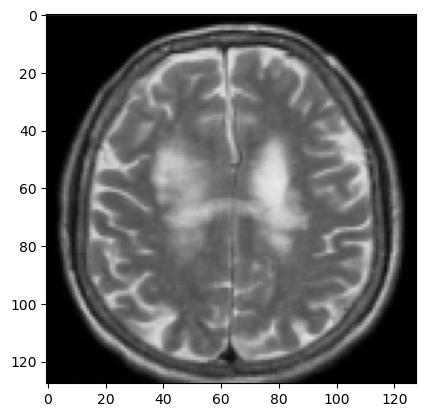

In [6]:
#To check the data

print(plt.imshow(data[233]))

# Splitting data to train and test

In [7]:
# Split the data into train and test sets
X_train, X_test,y_train, y_test= train_test_split(data, y, test_size= 0.2 , shuffle = True, random_state = 42)

# Defining the model

In [8]:

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters of size 2x2 and 'same' padding
# Input shape is (128, 128, 3)
model.add(Conv2D(32, (2, 2), padding='same', input_shape=(128, 128, 3)))
model.add(Activation('relu'))

# Add another convolutional layer with 32 filters of size 2x2
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))

# Add a max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Add a convolutional layer with 128 filters of size 2x2 and 'same' padding
model.add(Conv2D(128, (2, 2), padding='same'))
model.add(Activation('relu'))

# Add another convolutional layer with 64 filters of size 3x3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

# Add a max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer with a rate of 0.25
model.add(Dropout(0.25))

# Flatten the output from previous layers
model.add(Flatten())

# Reshape the flattened output to have shape (1, -1)
model.add(Reshape((1, -1)))

# Define the number of timesteps and features
timesteps = 1
features = 128 * 128 * 3

# Add a dropout layer with a rate of 0.25
model.add(Dropout(0.25))

# Add an LSTM layer with 120 units, using the defined timesteps and features
model.add(LSTM(units=120, input_shape=(timesteps, features), activation='relu'))

# Add a fully connected dense layer with 128 units and ReLU activation
model.add(Dense(128))
model.add(Activation('relu'))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add another fully connected dense layer with 64 units and ReLU activation
model.add(Dense(64))
model.add(Activation('relu'))

# Add the final dense layer with 4 units and softmax activation for classification
model.add(Dense(4, activation='softmax'))


2023-05-31 14:47:00.855136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 32)      4128      
                                                                 
 activation_1 (Activation)   (None, 127, 127, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                        

 # Compile the model

In [10]:
opt = Adam(learning_rate=0.0001) # Set the learning rate to 0.0001
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model and save the history
history = model.fit(X_train, y_train, batch_size=50, epochs=15, validation_data=(X_test, y_test), verbose=1)


Epoch 1/15
53/53 [==============================] - 139s 3s/step - loss: 1.3057 - accuracy: 0.3535 - val_loss: 1.2122 - val_accuracy: 0.4793
Epoch 2/15
53/53 [==============================] - 170s 3s/step - loss: 1.1337 - accuracy: 0.5029 - val_loss: 1.0142 - val_accuracy: 0.5299
Epoch 3/15
53/53 [==============================] - 136s 3s/step - loss: 0.9867 - accuracy: 0.5806 - val_loss: 0.9300 - val_accuracy: 0.5605
Epoch 4/15
53/53 [==============================] - 136s 3s/step - loss: 0.8790 - accuracy: 0.6293 - val_loss: 0.8182 - val_accuracy: 0.6478
Epoch 5/15
53/53 [==============================] - 136s 3s/step - loss: 0.7909 - accuracy: 0.6695 - val_loss: 0.7797 - val_accuracy: 0.6386
Epoch 6/15
53/53 [==============================] - 143s 3s/step - loss: 0.7173 - accuracy: 0.6990 - val_loss: 0.7285 - val_accuracy: 0.6631
Epoch 7/15
53/53 [==============================] - 153s 3s/step - loss: 0.6475 - accuracy: 0.7407 - val_loss: 0.6555 - val_accuracy: 0.7106
Epoch 8/15
53

# Evaluation

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


21/21 [==============================] - 10s 457ms/step - loss: 0.3720 - accuracy: 0.8928
Test loss: 0.37204599380493164
Test accuracy: 0.8928024768829346


In [12]:
from sklearn.metrics import precision_score, recall_score

# Split the data into train and test sets
X_train, X_test, y_train_temp, y_test_temp = train_test_split(data, ytemp, test_size=0.2, shuffle=True, random_state=42)

# Split y_train_temp into y_train and y_val with the same random state
y_train, y_val = train_test_split(y_train_temp, test_size=0.25, shuffle=True, random_state=42)

# Get predictions on the test set
y_pred = model.predict(X_test)

# Convert y_pred to a flat array of labels
y_pred_labels = np.argmax(y_pred, axis=1).flatten()

# Calculate precision and recall on y_test and y_pred_labels
precision = precision_score(y_test_temp, y_pred_labels, average='weighted')
recall = recall_score(y_test_temp, y_pred_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)


21/21 [==============================] - 10s 472ms/step
Precision: 0.8939142364116563
Recall: 0.892802450229709


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get predictions on the test set
y_pred = model.predict(X_test)

# Convert y_pred to a flat array of labels
y_pred_labels = np.argmax(y_pred, axis=1).flatten()

# Calculate precision, recall, F1 score, and accuracy on y_test and y_pred_labels
precision = precision_score(y_test_temp, y_pred_labels, average='weighted')
recall = recall_score(y_test_temp, y_pred_labels, average='weighted')
f1 = f1_score(y_test_temp, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_temp, y_pred_labels)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)
print('Accuracy:', accuracy)


21/21 [==============================] - 10s 479ms/step
Precision: 0.8939142364116563
Recall: 0.892802450229709
F1 score: 0.8924979332387369
Accuracy: 0.892802450229709


# Graph plot

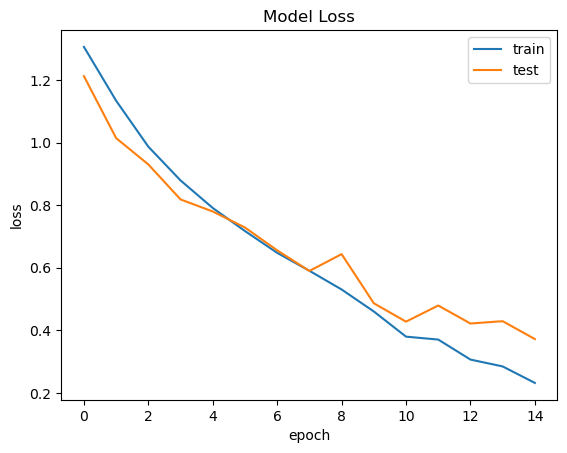

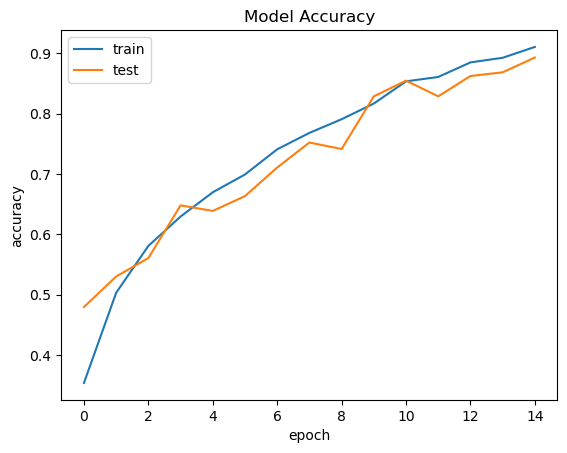

In [14]:
# Plot the training history for both loss and accuracy
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


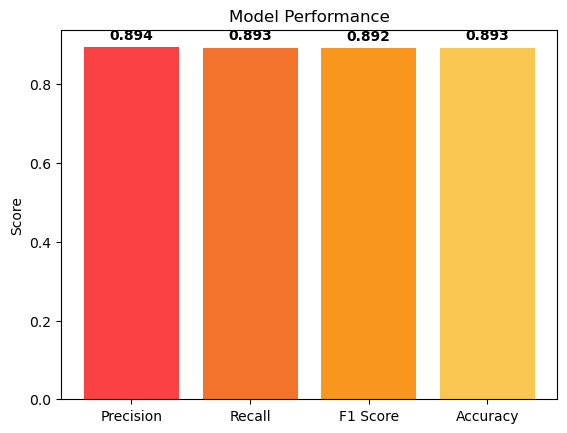

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metric values
precision = precision_score(y_test_temp, y_pred_labels, average='weighted')
recall = recall_score(y_test_temp, y_pred_labels, average='weighted')
f1 = f1_score(y_test_temp, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_temp, y_pred_labels)

# Define the colors for the bars
colors = ['#F94144', '#F3722C', '#F8961E', '#F9C74F']

# Create a vertical bar chart
fig, ax = plt.subplots()
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision, recall, f1, accuracy]
bars = ax.bar(metrics, values, color=colors)

# Add labels and title to the chart
plt.ylabel('Score')
plt.title('Model Performance')

# Add text labels to the bars
for i, bar in enumerate(bars):
    ax.text(i, bar.get_height() + 0.02, str(round(bar.get_height(), 3)),
            color='black', fontweight='bold', ha='center')

# Display the chart
plt.show()


21/21 [==============================] - 10s 476ms/step


<Axes: >

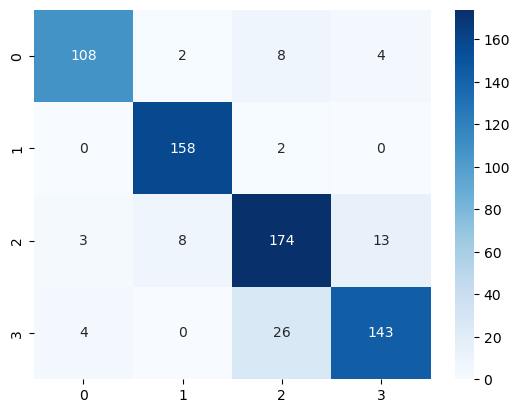

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
y_pred = model.predict(X_test)

# Convert y_pred to a flat array of labels
y_pred_labels = np.argmax(y_pred, axis=1).flatten()

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test_temp, y_pred_labels)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")


# rows are true labels

# columns are predicted labels

# diagonal predictions are correct predictions , non diagonal predictions are incorrect predictions

# the internal numbers in each cell represent the count of samples in that category